In [1]:
import matplotlib.pyplot as plt
import nltk
import numpy as np
import seaborn as sns
import pandas as pd
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.metrics import (accuracy_score, f1_score, precision_score,
                             recall_score)
from wordcloud import WordCloud
import random
import re

from sklearn.model_selection import train_test_split


nltk.download('stopwords')
nltk.download('punkt')
stop_words = set(stopwords.words('russian'))

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/habkaffee/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/habkaffee/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


# EDA

Setting seeds

In [2]:
seed = 42
random.seed(seed)
np.random.seed(seed)

Dataset was taken from https://www.kaggle.com/datasets/constantinwerner/multilingual-ner-dataset?select=rus.tsv and a bit processed manually. Sentences were separated with empty line. Instead of empty line <EOS> tag was placed.

In [3]:
def parse_dataset_to_sentences(path):
    sentences = []
    current = []
    tags = set()
    
    with open(path) as f:
        for line in f:
            if line.strip() == '<EOS>':
                sentences.append(current)
                current = []
                continue
            tags.add(line.split()[1])
            current.append(line.split())
        if len(current):
            sentences.append(current)
    return sentences, tags

In [4]:
parsed_data, tags = parse_dataset_to_sentences('data/rus.tsv')
tags

{'B-CARDINAL',
 'B-DATE',
 'B-EVENT',
 'B-FAC',
 'B-GPE',
 'B-LANGUAGE',
 'B-LOC',
 'B-MONEY',
 'B-NORP',
 'B-ORDINAL',
 'B-ORG',
 'B-PERCENT',
 'B-PERSON',
 'B-PRODUCT',
 'B-QUANTITY',
 'B-TIME',
 'B-WORK_OF_ART',
 'I-CARDINAL',
 'I-DATE',
 'I-EVENT',
 'I-FAC',
 'I-GPE',
 'I-LANGUAGE',
 'I-LOC',
 'I-MONEY',
 'I-NORP',
 'I-ORG',
 'I-PERCENT',
 'I-PERSON',
 'I-PRODUCT',
 'I-QUANTITY',
 'I-TIME',
 'I-WORK_OF_ART',
 'O'}

Tag description:
 - CARDINAL - Numerals that do not fall under another type
 - DATE - Absolute or relative dates or periods
 - EVENT - Named hurricanes, battles, wars, sports events, etc
 - FAC -Buildings, airports, highways, bridges, etc
 - GPE - Countries, cities, states
 - LANGUAGE - Any named language.
 - LOC - Non-GPE locations, mountain ranges, bodies of water
 - MONEY - Monetary values, including unit
 - NORP - Nationalities or religious or political groups
 - ORDINAL - “first”, “second”, etc.
 - ORG - Companies, agencies, institutions, etc
 - PERCENT - Percentage, including ”%“.
 - PERSON - People, including fictional
 - PRODUCT - Objects, vehicles, foods, etc. (Not services.)
 - QUANTITY - Measurements, as of weight or distance
 - TIME - Times smaller than a day
 - WORK_OF_ART - Titles of books, songs, etc
 - O - other (no named entity)

In [5]:
tts_ratio = 0.2
train, test = train_test_split(parsed_data, test_size=tts_ratio)
print(f'Train/test ratio -> {tts_ratio}\nTrain size -> {len(train)}\nTest size -> {len(test)}\nTotal size -> {len(train) + len(test)}')

Train/test ratio -> 0.2
Train size -> 1059
Test size -> 265
Total size -> 1324


In [6]:
def get_quantity_per_tag(data, tags):
    labels = {label : 0 for label in tags}
    for sentence in data:
        for ent in sentence:
            labels[ent[1]] += 1
    return labels

In [7]:
train_distrib = get_quantity_per_tag(train, tags)
test_distrib = get_quantity_per_tag(test, tags)

In [8]:
train_distrib

{'I-NORP': 1,
 'O': 19302,
 'I-FAC': 19,
 'B-LANGUAGE': 3,
 'I-PRODUCT': 2,
 'B-EVENT': 12,
 'B-CARDINAL': 183,
 'B-WORK_OF_ART': 9,
 'I-MONEY': 74,
 'I-CARDINAL': 21,
 'I-EVENT': 19,
 'B-PRODUCT': 7,
 'B-PERCENT': 23,
 'B-DATE': 345,
 'B-ORG': 547,
 'I-TIME': 42,
 'B-QUANTITY': 15,
 'B-ORDINAL': 77,
 'B-MONEY': 34,
 'I-DATE': 327,
 'B-NORP': 223,
 'I-ORG': 296,
 'B-LOC': 86,
 'I-PERSON': 410,
 'I-QUANTITY': 16,
 'I-LANGUAGE': 2,
 'I-GPE': 53,
 'B-TIME': 40,
 'B-GPE': 692,
 'I-PERCENT': 22,
 'I-LOC': 42,
 'B-FAC': 40,
 'B-PERSON': 560,
 'I-WORK_OF_ART': 8}

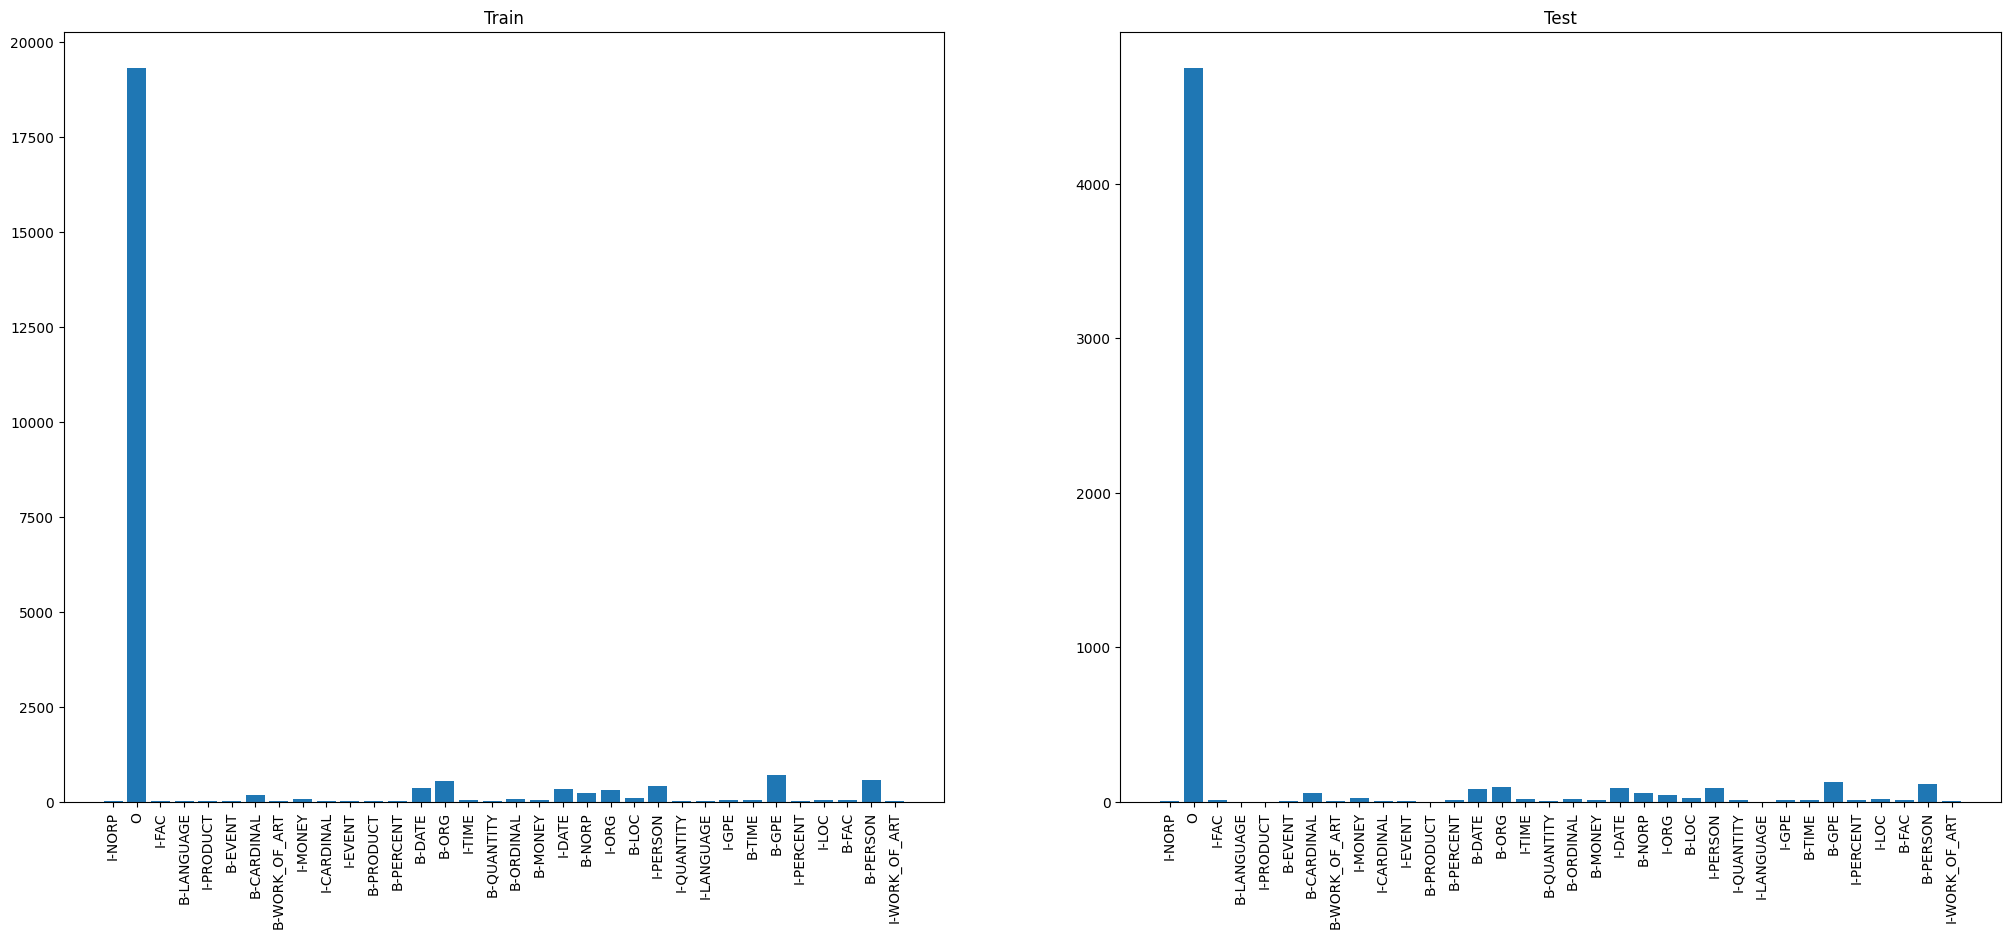

In [9]:
fig, axes = plt.subplots(1,2, figsize=(25,10))
datasets = [train_distrib, test_distrib]
titles = ['Train', 'Test']
for i, ax in enumerate(axes):
    ax.bar(
        x=list(datasets[i].keys()),
        height=list(datasets[i].values())
    )
    ax.tick_params(axis='x', labelrotation=90)
    ax.set_title(titles[i])
plt.show()

Amount of 'o' (other) tags makes chart not informative. Let's exclude it to see labels distribution

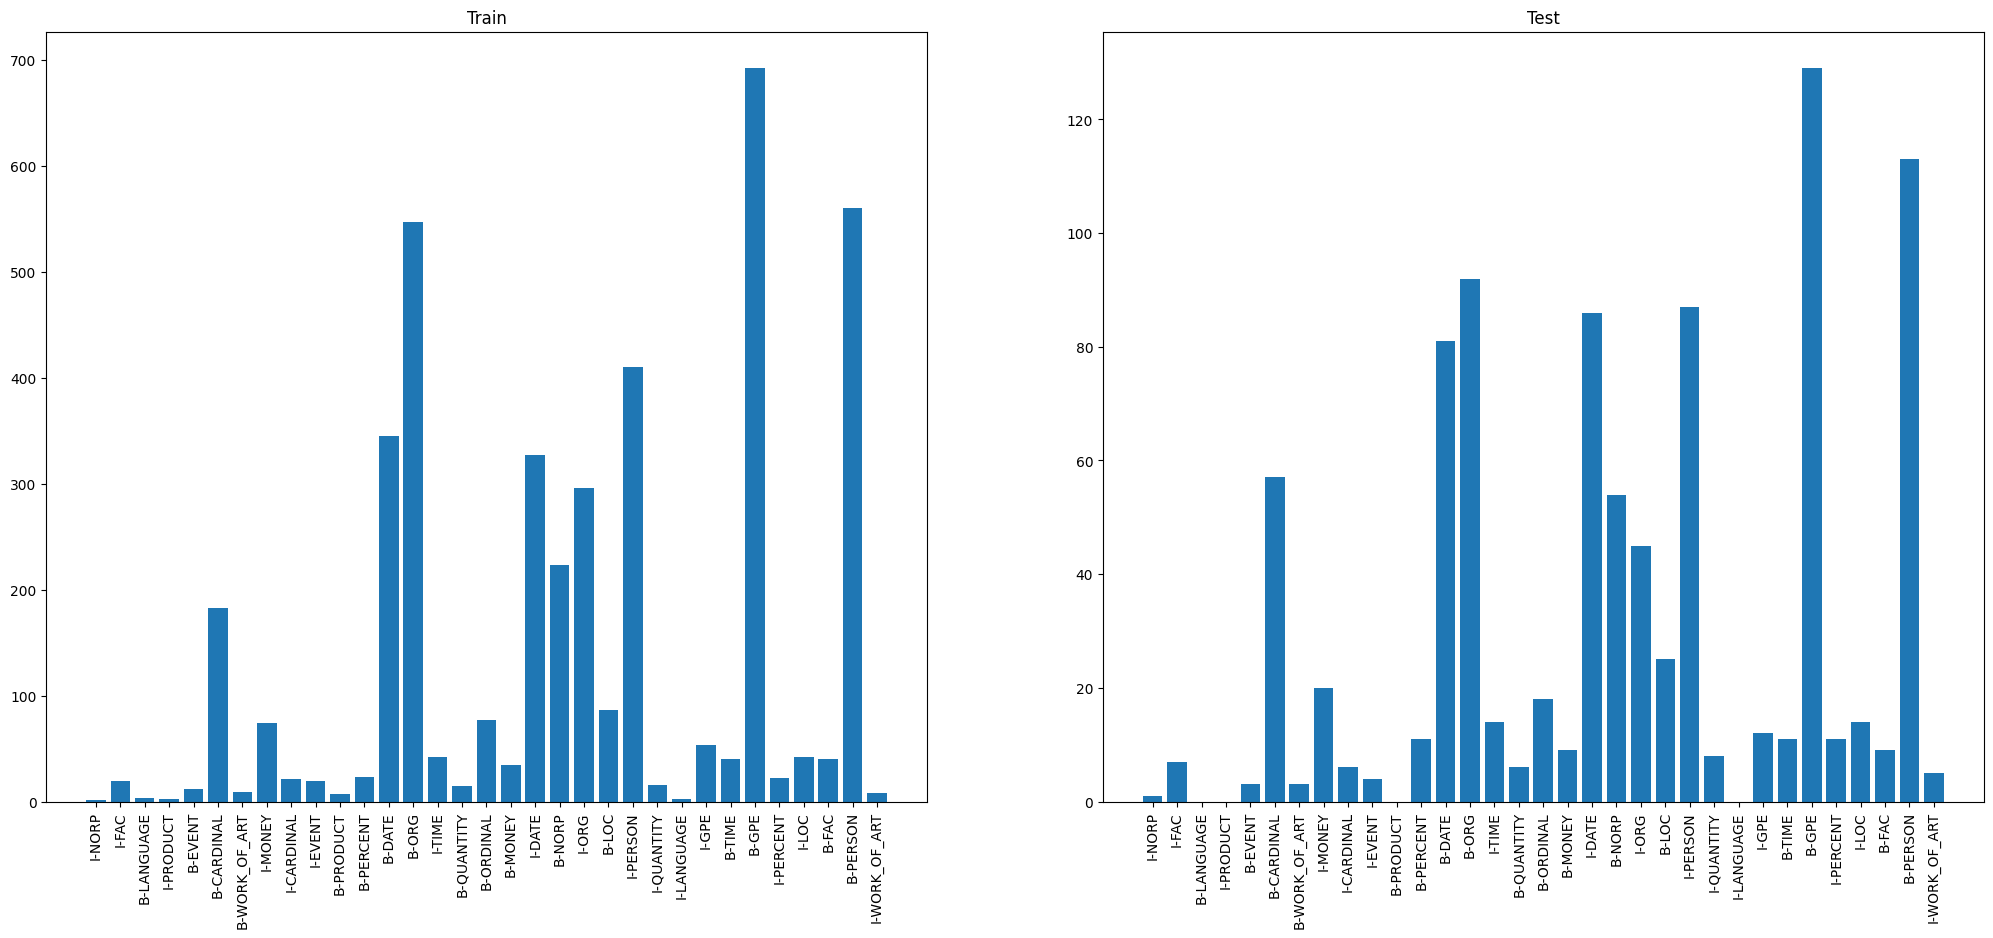

In [10]:
fig, axes = plt.subplots(1,2, figsize=(25,10))
train_distrib_named_only = train_distrib
test_distrib_named_only = test_distrib
if 'O' in train_distrib_named_only.keys():
    train_distrib_named_only.pop('O')
    test_distrib_named_only.pop('O')
datasets = [train_distrib_named_only,test_distrib_named_only]
titles = ['Train', 'Test']
for i, ax in enumerate(axes):
    ax.bar(
        x=list(datasets[i].keys()),
        height=list(datasets[i].values()),
        
    )
    ax.tick_params(axis='x', labelrotation=90)
    ax.set_title(titles[i])
plt.show()

In both train and test subsets B-GPE, B-ORG, and B-PERSON took top-3 of all tags. I-LANGUAGE, I-NORP, and I-product took ending 3 places. It means that that usually 'language name', 'nationalities, religion...' and 'Objects, vehicles, foods, etc. (Not services.)' consist of no more than 2 words.

Other notable feature is that some tags facing in test dataset and not in train, like I-NORP, B-LANGUAGE and I-LANGUAGE. That will lead to decrease of model efficiency. To avoid the problem we should try to use stratified train_test_split.

In [ ]:
# df = pd.DataFrame([words + [i] for i, sentence in enumerate(parsed_data) for words in sentence], columns=["word", "tag", "sentence_id"])
# df.head(25)

In [13]:
# train, test = train_test_split(df, test_size=tts_ratio, stratify=df['tag'])

# fig, axes = plt.subplots(1,2, figsize=(25,10))

# datasets = [train['tag'].value_counts().drop('O'), test['tag'].value_counts().drop('O')]
# titles = ['Train', 'Test']
# for i, ax in enumerate(axes):
#     ax.bar(
#         x=datasets[i].index,
#         height=datasets[i].values,
#     )
#     ax.tick_params(axis='x', labelrotation=90)
#     ax.set_title(titles[i])
# plt.show()

In [14]:
train_starts = {
    'CARDINAL' : {'B':0,'I':0},
    'DATE' : {'B':0,'I':0},
    'EVENT' : {'B':0,'I':0},
    'FAC' : {'B':0,'I':0},
    'GPE' : {'B':0,'I':0},
    'LANGUAGE' : {'B':0,'I':0},
    'LOC' : {'B':0,'I':0},
    'MONEY' : {'B':0,'I':0},
    'NORP' : {'B':0,'I':0},
    'ORG' : {'B':0,'I':0},
    'ORDINAL' : {'B':0,'I':0},
    'PERCENT' : {'B':0,'I':0},
    'PERSON' : {'B':0,'I':0},
    'PRODUCT' : {'B':0,'I':0},
    'QUANTITY' : {'B':0,'I':0},
    'TIME' : {'B':0,'I':0},
    'WORK_OF_ART' : {'B':0,'I':0},
}
test_starts = {
    'CARDINAL' : {'B':0,'I':0},
    'DATE' : {'B':0,'I':0},
    'EVENT' : {'B':0,'I':0},
    'FAC' : {'B':0,'I':0},
    'GPE' : {'B':0,'I':0},
    'LANGUAGE' : {'B':0,'I':0},
    'LOC' : {'B':0,'I':0},
    'MONEY' : {'B':0,'I':0},
    'NORP' : {'B':0,'I':0},
    'ORG' : {'B':0,'I':0},
    'ORDINAL' : {'B':0,'I':0},
    'PERCENT' : {'B':0,'I':0},
    'PERSON' : {'B':0,'I':0},
    'PRODUCT' : {'B':0,'I':0},
    'QUANTITY' : {'B':0,'I':0},
    'TIME' : {'B':0,'I':0},
    'WORK_OF_ART' : {'B':0,'I':0},
}

In [15]:
for key in train_distrib_named_only.keys():
    key_str = key[2:]
    train_starts[key_str][key[0]] += train_distrib_named_only[key]
train_starts

{'CARDINAL': {'B': 183, 'I': 21},
 'DATE': {'B': 345, 'I': 327},
 'EVENT': {'B': 12, 'I': 19},
 'FAC': {'B': 40, 'I': 19},
 'GPE': {'B': 692, 'I': 53},
 'LANGUAGE': {'B': 3, 'I': 2},
 'LOC': {'B': 86, 'I': 42},
 'MONEY': {'B': 34, 'I': 74},
 'NORP': {'B': 223, 'I': 1},
 'ORG': {'B': 547, 'I': 296},
 'ORDINAL': {'B': 77, 'I': 0},
 'PERCENT': {'B': 23, 'I': 22},
 'PERSON': {'B': 560, 'I': 410},
 'PRODUCT': {'B': 7, 'I': 2},
 'QUANTITY': {'B': 15, 'I': 16},
 'TIME': {'B': 40, 'I': 42},
 'WORK_OF_ART': {'B': 9, 'I': 8}}

In [16]:
for key in test_distrib_named_only.keys():
    key_str = key[2:]
    test_starts[key_str][key[0]] += test_distrib_named_only[key]
test_starts

{'CARDINAL': {'B': 57, 'I': 6},
 'DATE': {'B': 81, 'I': 86},
 'EVENT': {'B': 3, 'I': 4},
 'FAC': {'B': 9, 'I': 7},
 'GPE': {'B': 129, 'I': 12},
 'LANGUAGE': {'B': 0, 'I': 0},
 'LOC': {'B': 25, 'I': 14},
 'MONEY': {'B': 9, 'I': 20},
 'NORP': {'B': 54, 'I': 1},
 'ORG': {'B': 92, 'I': 45},
 'ORDINAL': {'B': 18, 'I': 0},
 'PERCENT': {'B': 11, 'I': 11},
 'PERSON': {'B': 113, 'I': 87},
 'PRODUCT': {'B': 0, 'I': 0},
 'QUANTITY': {'B': 6, 'I': 8},
 'TIME': {'B': 11, 'I': 14},
 'WORK_OF_ART': {'B': 3, 'I': 5}}

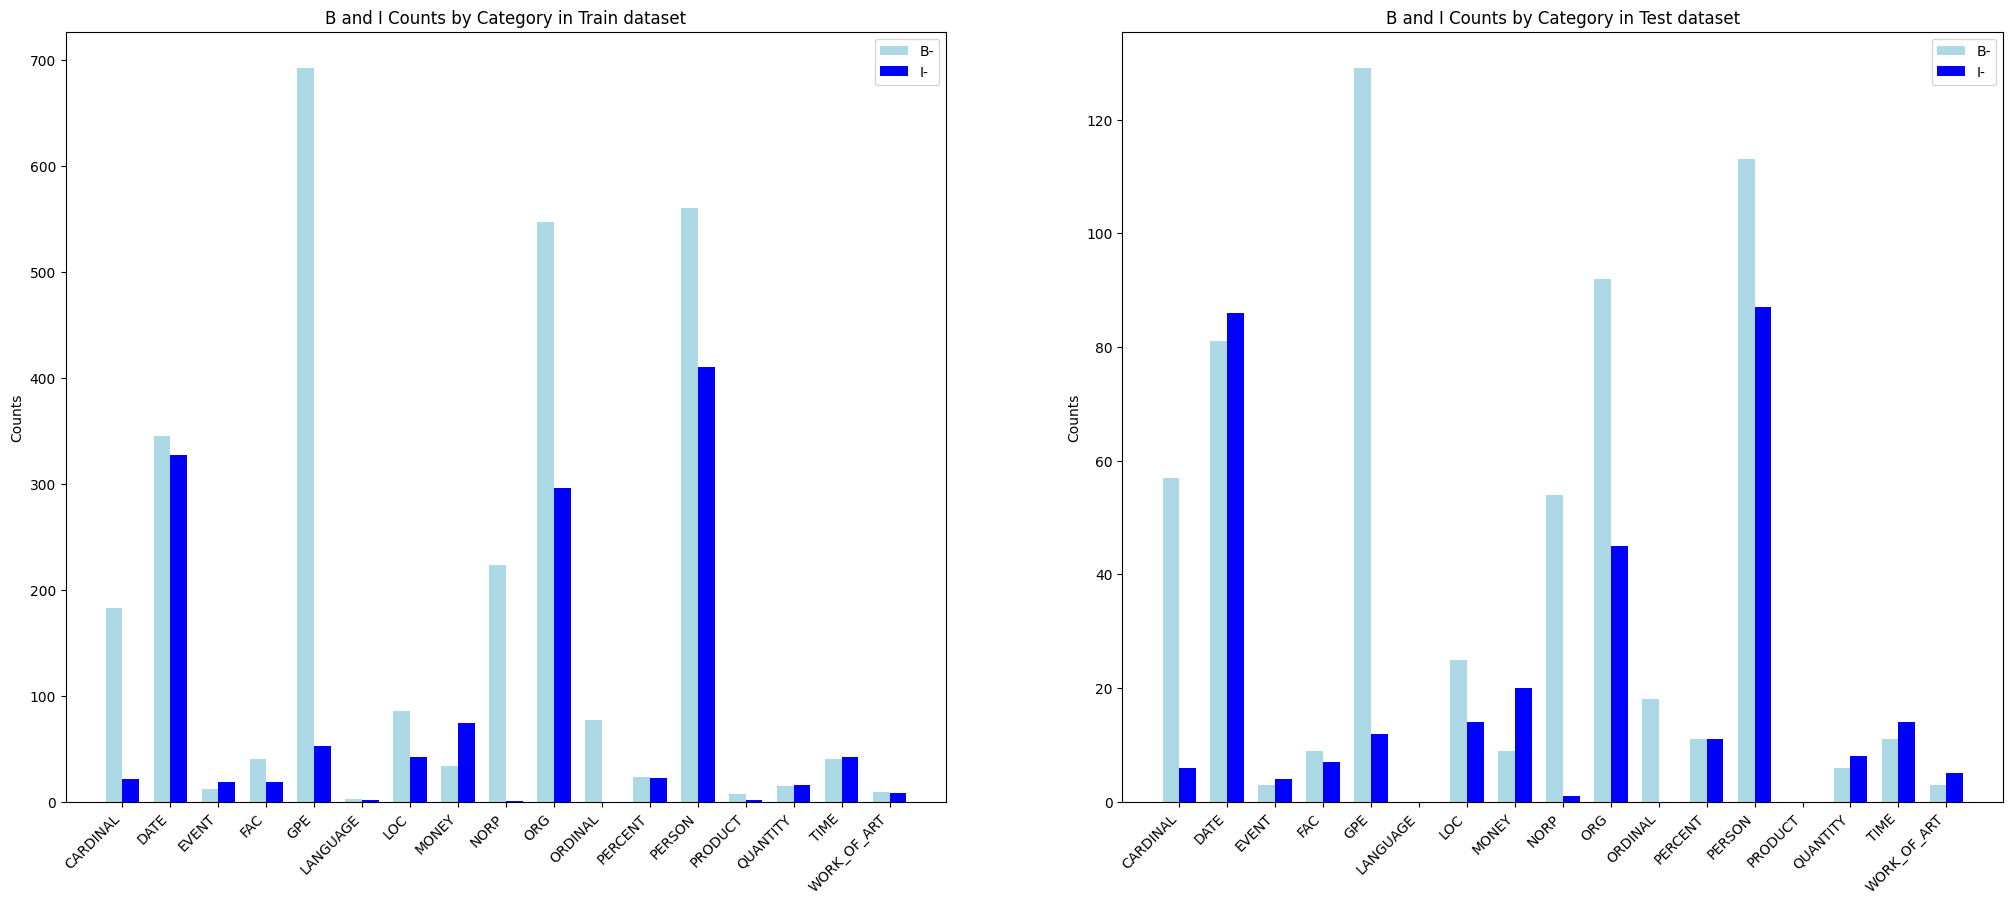

In [17]:
fig, axes = plt.subplots(1,2, figsize=(25,10))

datasets = [train_starts, test_starts]
titles = ['Train', 'Test']
for i, ax in enumerate(axes):
    categories = list(datasets[i].keys())
    B_values = [datasets[i][cat]['B'] for cat in categories]
    I_values = [datasets[i][cat]['I'] for cat in categories]
    width = 0.35
    x = np.arange(len(categories))
    rects1 = ax.bar(x - width/2, B_values, width, label='B-', color='lightblue')
    rects2 = ax.bar(x + width/2, I_values, width, label='I-', color='blue')
    ax.set_ylabel('Counts')
    ax.set_title(f'B and I Counts by Category in {titles[i]} dataset')
    ax.set_xticks(x)
    ax.set_xticklabels(categories, rotation=45, ha='right')
    ax.legend()
plt.show()

According to the bar chart above, classes 'Date', 'ORG', 'Person' in both train and test datasets contain more than 2 words, while 'Cardinal', 'GPE', 'NORP' usually contain 1 word

In [18]:
# def func(x):
    
    
# train.groupby('sentence_id').apply(lambda x: myfunc(x.var1))
# result = train.groupby('sentence_id')['word'].apply(lambda x: ' '.join(x)).reset_index()

# # Переименуем колонку для удобства
# result.rename(columns={'words': 'sentence'}, inplace=True)
# result

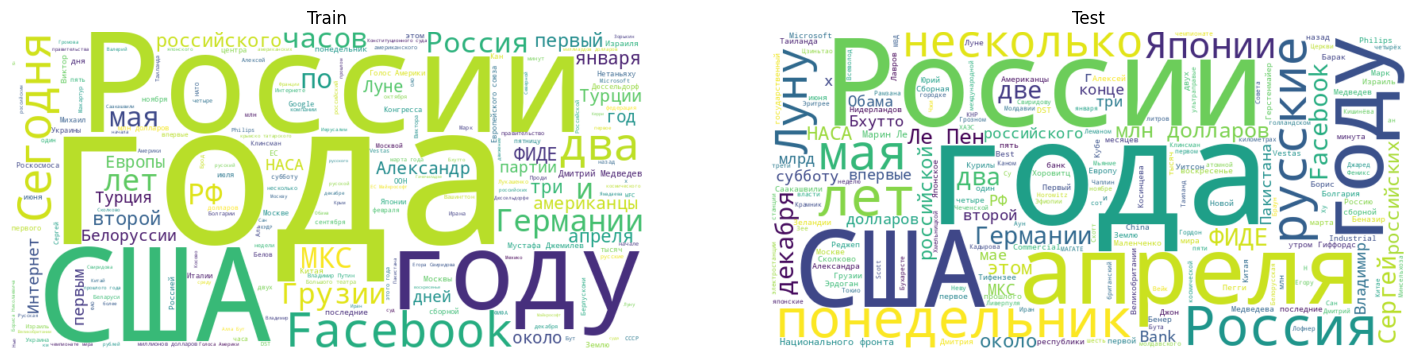

In [19]:
datasets = [train, test]
titles = ['Train', 'Test']
fig, axes = plt.subplots(1, len(datasets), figsize=(18,6))
for i in range(len(datasets)):
    text = " ".join([token for sentence in datasets[i] for token, label in sentence if label != 'O'])

    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

    axes[i].imshow(wordcloud, interpolation='bilinear')
    axes[i].axis('off')
    axes[i].set_title(titles[i])
plt.show()

Most common words in train datasets are:
  - Года and its forms
  - Россия
  - США
  - Facebook

Most common words in test datasets are:
  - Года and its forms
  - Россия
  - США
  - Facebook

It means that such words are widely used in news .....

# Rule-based approach

In [20]:
import spacy
from spacy.pipeline import EntityRuler

rule_based_model = spacy.load('ru_core_news_md')

ruler = rule_based_model.add_pipe("entity_ruler", before="ner")

# Define patterns
patterns = [
    {"label": "ORDINAL", "pattern": [{"LOWER": {"REGEX": "^(первый|второй|третий|четвёртый|пятый|шестой|седьмой|восьмой|девятый|нулевой)$"}}]},
    {"label": "ORDINAL", "pattern": [{"TEXT": {"REGEX": "^\\d+-й$"}}]},
    {"label": "CARDINAL", "pattern": [{"TEXT": {"REGEX": "^\\d+$"}}]},
    {"label": "DATE", "pattern": [{"TEXT": {"REGEX": "\\d{2}\\.\\d{2}\\.\\d{4}"}}]},
    {"label": "DATE", "pattern": [{"TEXT": {"REGEX": "\\d{1,2} \\w+ \\d{4}"}}]},
    {"label": "EVENT", "pattern": [{"LOWER": {"IN": ["Новогодние каникулы", "Рождество Христово", 
                                                     "День защитника Отечества", "Международный женский день",
                                                     "Праздник Весны и Труда", "День Победы", 
                                                     "День России", "День народного единства"]}}]},
    {"label": "FAC", "pattern": [{"TEXT": {"REGEX": "^[А-Я][а-я]+ский мост$"}}]},
    {"label": "FAC", "pattern": [{"TEXT": {"REGEX": "^[А-Я][а-я]+ская башня$"}}]},
    {"label": "GPE", "pattern": [{"TEXT": {"REGEX": "США|Росси[а-я]+|Япони[а-я]+|Москв[а-я]+|Грузи[а-я]+|ЕС"}}]},
    {"label": "LANGUAGE", "pattern": [{"LOWER": {"IN": ["русский", "английский", "китайский", "французский", "японский"]}}]},
    {"label": "LOC", "pattern": [{"TEXT": {"REGEX": "^[А-Я][а-я]+ (гор[а-я]*|рек[а-я]|озер[а-я])$"}}]},
    {"label": "LOC", "pattern": [{"TEXT": {"REGEX": "^река [А-Я][а-я]+$"}}]},
    {"label": "MONEY", "pattern": [{"TEXT": {"REGEX": "^\\d+ руб\\.$"}}]},
    {"label": "MONEY", "pattern": [{"TEXT": {"REGEX": "^\\d+\\s+₽$"}}]},
    {"label": "NORP", "pattern": [{"LOWER": {"IN": ["русский", "немец", "еврей",
                                                    "грузин", "японец", "русская",
                                                    "немка", "еврейка", "грузинка",
                                                    "японка", "православный", "мусульманин",
                                                    "православная", "мусульманка"]}}]},
    {"label": "ORG", "pattern": [{"TEXT": {"REGEX": "^[А-Я][а-я]+[-]*банк$"}}]},
    {"label": "ORG", "pattern": [{"LOWER": {"IN": ["газпром", "яндекс", "озон", "магнит", "пятерочка"]}}]},
    {"label": "PERCENT", "pattern": [{"TEXT": {"REGEX": "^\\d+%$"}}]},
    {"label": "PERCENT", "pattern": [{"TEXT": {"REGEX": "^\\d+ проц\\.$"}}]},
    {"label": "PERSON", "pattern": [{"TEXT": {"REGEX": "^[А-ЯЁ][а-яё]+ [А-ЯЁ][а-яё]+$"}}]},
    {"label": "PERSON", "pattern": [{"TEXT": {"REGEX": "^(г-н|г-жа|тов\\.)? ?[А-ЯЁ][а-яё]+ [А-ЯЁ][а-яё]+$"}}]},
    {"label": "PERSON", "pattern": [{"TEXT": {"REGEX": "^[А-ЯЁ][а-яё]+ [А-ЯЁ][а-яё]+( [А-ЯЁ][а-яё]+)?$"}}]},
    {"label": "PRODUCT", "pattern": [{"TEXT": {"REGEX": "^[А-Я][а-я]+фон$"}}]},
    {"label": "PRODUCT", "pattern": [{"TEXT": {"REGEX": "^[А-Я][а-я]+ный товар$"}}]},
    {"label": "QUANTITY", "pattern": [{"TEXT": {"REGEX": "^\\d+ [к|м]*г$"}}]},
    {"label": "QUANTITY", "pattern": [{"TEXT": {"REGEX": "^\\d+ [милли]*литров$"}}]},
    {"label": "TIME", "pattern": [{"TEXT": {"REGEX": "^\\d+:\\d+$"}}]},
    {"label": "TIME", "pattern": [{"TEXT": {"REGEX": "^\\d+ [секунд|минут|часов]$"}}]},
    {"label": "WORK_OF_ART", "pattern": [{"TEXT": {"REGEX": "^[«\"]\\w+[»\"]$"}}]},
    {"label": "WORK_OF_ART", "pattern": [{"TEXT": {"REGEX": "^[А-Я][а-я]+ \\w+$"}}]},
]

ruler.add_patterns(patterns)

In [21]:
from spacy import displacy
doc = rule_based_model(' '.join([i[0] for i in test[20]]))

for ent in doc.ents:
    print(f"{ent.text}: {ent.label_}")

displacy.render(doc, style="ent", jupyter=True)

Китае: LOC
Кубе: LOC
Эритрее: LOC
Эфиопии: LOC


In [22]:
mapping = {
    'B-CARDINAL' : 'CARDINAL',
    'B-DATE' : 'DATE',
    'B-EVENT' : 'EVENT',
    'B-FAC' : 'FAC',
    'B-GPE' : 'GPE',
    'B-LANGUAGE' : 'LANGUAGE',
    'B-LOC' : 'LOC',
    'B-MONEY' : 'MONEY',
    'B-NORP' : 'NORP',
    'B-ORDINAL' : 'ORDINAL',
    'B-ORG' : 'ORG',
    'B-PERCENT' : 'PERCENT',
    'B-PERSON' : 'PER',
    'B-PRODUCT' : 'PRODUCT',
    'B-QUANTITY' : 'QUANTITY',
    'B-TIME' : 'TIME',
    'B-WORK_OF_ART' : 'WORK_OF_ART',
    'I-CARDINAL' : 'CARDINAL',
    'I-DATE' : 'DATE',
    'I-EVENT' : 'EVENT',
    'I-FAC' : 'FAC',
    'I-GPE' : 'GPE',
    'I-LANGUAGE' : 'LANGUAGE',
    'I-LOC' : 'LOC',
    'I-MONEY' : 'MONEY',
    'I-NORP' : 'NORP',
    'I-ORG' : 'ORG',
    'I-PERCENT' : 'PERCENT',
    'I-PERSON' : 'PER',
    'I-PRODUCT' : 'PRODUCT',
    'I-QUANTITY' : 'QUANTITY',
    'I-TIME' : 'TIME',
    'I-WORK_OF_ART' : 'WORK_OF_ART',
    'O' : 'O'
}

In [23]:
from tqdm import tqdm

def calculate_metrics(data, model):
    metrics = {
        'accuracy' : 0,
        'precision' : 0,
        'recall' : 0,
        'f1_macro' : 0
    }
    all_y_true = []
    all_y_pred = []
    for sentence in tqdm(data):
        # print(data)
        model_resp = model(' '.join(word[0] for word in sentence))
        y_pred = []
        y_true = []
        for token in model_resp:
            y_pred.append(token.ent_type_ if token.ent_type_ else 'O')
        for word in sentence:
            y_true.append(mapping[word[1]])
        if len(y_true) != len(y_pred):
            continue
        all_y_true.extend(y_true)
        all_y_pred.extend(y_pred)
    print(len(all_y_pred), len(all_y_true))
    metrics['accuracy'] = accuracy_score(all_y_true, all_y_pred)
    metrics['precision'] = precision_score(all_y_true, all_y_pred, average='macro')
    metrics['recall'] = recall_score(all_y_true, all_y_pred, average='macro')
    metrics['f1_macro'] = f1_score(all_y_true, all_y_pred, average='macro')
    return metrics

In [24]:
metrics = calculate_metrics(test, rule_based_model)
metrics

100%|██████████| 265/265 [00:01<00:00, 144.29it/s]

4785 4785



/home/habkaffee/programming/nlp/lab_2/venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/habkaffee/programming/nlp/lab_2/venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


{'accuracy': 0.8950888192267502,
 'precision': 0.27084370404700814,
 'recall': 0.26192991189251497,
 'f1_macro': 0.2393409055243777}

This metrics show that rule based approach not really good, because accuracy is not really representative. This approach also one of the hardest, because we need to know the target language really well in order to provide correct regex for each case.

# NN Approach

In [25]:
import torch
from torch.utils.data import Dataset, DataLoader

parsed_data, tags = parse_dataset_to_sentences('data/rus.tsv')
sentences, labels = [[word[0] for word in sentence] for sentence in parsed_data], [[mapping[word[1]] for word in sentence] for sentence in parsed_data]

word2idx = {"<PAD>": 0, "<UNK>": 1}
label2idx = {'O': 0}

for sentence in sentences:
    for word in sentence:
        if word not in word2idx:
            word2idx[word] = len(word2idx)

for label_seq in labels:
    for label in label_seq:
        if label not in label2idx:
            label2idx[label] = len(label2idx)

idx2label = {v: k for k, v in label2idx.items()}

In [26]:
def encode_sentences(sentences, word2idx):
    return [[word2idx.get(word, word2idx["<UNK>"]) for word in sentence] for sentence in sentences]

def encode_labels(labels, label2idx):
    return [[label2idx[label] for label in label_seq] for label_seq in labels]

X = encode_sentences(sentences, word2idx)
# X_char = encode_by_chars(sentences, char2idx)
y = encode_labels(labels, label2idx)

def pad_sequences(sequences, pad_value):
    max_len = max(len(seq) for seq in sequences)
    return [seq + [pad_value] * (max_len - len(seq)) for seq in sequences]

X = pad_sequences(X, word2idx["<PAD>"])
y = pad_sequences(y, label2idx["O"])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4)

X_train, X_test = torch.tensor(X_train, dtype=torch.long), torch.tensor(X_test, dtype=torch.long)
y_train, y_test = torch.tensor(y_train, dtype=torch.long), torch.tensor(y_test, dtype=torch.long)

In [27]:
class NERDataset(Dataset):
    def __init__(self, sentences, labels):
        self.sentences = sentences
        self.labels = labels

    def __len__(self):
        return len(self.sentences)

    def __getitem__(self, idx):
        return self.sentences[idx], self.labels[idx]

train_dataset = NERDataset(X_train, y_train)
test_dataset = NERDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


In [28]:
import torch.nn as nn
import torch.nn.functional as F
from torchcrf import CRF

class BiLSTMNER(nn.Module):
    def __init__(self, vocab_size, tagset_size, embedding_dim=128, hidden_dim=256):
        super(BiLSTMNER, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
        self.dropout = nn.Dropout(0.5)

        self.lstm = nn.LSTM(embedding_dim, hidden_dim // 2, num_layers=1, bidirectional=True, batch_first=True)
        self.fc = nn.Linear(hidden_dim, tagset_size)
        self.crf = CRF(tagset_size, batch_first=True)

    def forward(self, sentences, tags=None):
        embedded = self.embedding(sentences)  # (batch_size, seq_len, embedding_dim)
        embedded = self.dropout(embedded) 
        lstm_out, _ = self.lstm(embedded)  # (batch_size, seq_len, hidden_dim)
        
        emissions = self.fc(lstm_out)  # (batch_size, seq_len, tagset_size)
        
        if tags is not None:
            mask = sentences.ne(0).byte()  # Create mask for padding
            return -self.crf(emissions, tags, mask=mask)
        else:
            # During inference, when tags are not provided
            return self.crf.decode(emissions)


In [29]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = BiLSTMNER(vocab_size=len(word2idx), tagset_size=len(label2idx)).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Training loop
def train_model(model, train_loader, optimizer, num_epochs=5):
    model.train()
    for epoch in range(num_epochs):
        total_loss = 0
        for sentences, labels in train_loader:
            sentences, labels = sentences.to(device), labels.to(device)
            optimizer.zero_grad()
            
            loss = model(sentences, labels)
            total_loss += loss.item()
            
            # Backward pass
            loss.backward()
            optimizer.step()
        
        print(f"Epoch {epoch + 1}, Loss: {total_loss / len(train_loader)}")



In [30]:
train_model(model, train_loader, optimizer, num_epochs=75)

/home/habkaffee/programming/nlp/lab_2/venv/lib/python3.12/site-packages/torchcrf/__init__.py:249: UserWarning: where received a uint8 condition tensor. This behavior is deprecated and will be removed in a future version of PyTorch. Use a boolean condition instead. (Triggered internally at ../aten/src/ATen/native/TensorCompare.cpp:530.)
  score = torch.where(mask[i].unsqueeze(1), next_score, score)


Epoch 1, Loss: 1343.2926049804687
Epoch 2, Loss: 612.0004150390625
Epoch 3, Loss: 575.4281115722656
Epoch 4, Loss: 558.871064453125
Epoch 5, Loss: 541.3315783691406
Epoch 6, Loss: 522.5643139648438
Epoch 7, Loss: 502.64916259765624
Epoch 8, Loss: 476.97231201171877
Epoch 9, Loss: 452.55493530273435
Epoch 10, Loss: 432.12229736328123
Epoch 11, Loss: 410.0293444824219
Epoch 12, Loss: 390.15723876953126
Epoch 13, Loss: 372.1158703613281
Epoch 14, Loss: 354.38248168945313
Epoch 15, Loss: 334.4812786865234
Epoch 16, Loss: 318.29948974609374
Epoch 17, Loss: 300.5002618408203
Epoch 18, Loss: 289.7689221191406
Epoch 19, Loss: 273.25423706054687
Epoch 20, Loss: 257.16605407714843
Epoch 21, Loss: 248.5223095703125
Epoch 22, Loss: 234.560986328125
Epoch 23, Loss: 225.03829223632812
Epoch 24, Loss: 211.51913330078125
Epoch 25, Loss: 201.9401593017578
Epoch 26, Loss: 198.93141357421874
Epoch 27, Loss: 185.73990020751953
Epoch 28, Loss: 174.53650146484375
Epoch 29, Loss: 170.61798858642578
Epoch 30,

In [31]:
from sklearn.metrics import precision_recall_fscore_support

def evaluate_model(model, test_loader, idx2label):
    model.eval()
    all_predictions = []
    all_labels = []
    
    with torch.no_grad():
        for sentences, labels in test_loader:
            sentences = sentences.to(device)
            labels = labels.to(device)

            predictions = model(sentences)
            
            predictions = torch.tensor(predictions, device=device)
            
            # Ignore padding
            mask = labels != word2idx["<PAD>"]
            
            all_predictions.extend(predictions[mask].cpu().numpy())
            all_labels.extend(labels[mask].cpu().numpy())

    all_predictions = [idx2label[pred] for pred in all_predictions]
    all_labels = [idx2label[label] for label in all_labels]

    accuracy = accuracy_score(all_labels, all_predictions)
    precision, recall, f1, _ = precision_recall_fscore_support(all_labels, all_predictions, average='weighted')

    print(f"Overall Metrics:")
    print(f'Accuracy: {accuracy:.4f}')
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-score: {f1:.4f}")

    # Calculate metrics for each entity type
    labels = list(set(all_labels) - set(['O']))
    precision, recall, f1, _ = precision_recall_fscore_support(all_labels, all_predictions, labels=labels, average=None)

    print("\nMetrics by Entity Type:")
    for label, p, r, f in zip(labels, precision, recall, f1):
        print(f"{label}:")
        print(f"  Precision: {p:.4f}")
        print(f"  Recall: {r:.4f}")
        print(f"  F1-score: {f:.4f}")

    return precision, recall, f1

precision, recall, f1 = evaluate_model(model, test_loader, idx2label)


Overall Metrics:
Accuracy: 0.4807
Precision: 0.8612
Recall: 0.4807
F1-score: 0.6065

Metrics by Entity Type:
DATE:
  Precision: 0.9675
  Recall: 0.7190
  F1-score: 0.8250
NORP:
  Precision: 0.8333
  Recall: 0.2991
  F1-score: 0.4403
PERCENT:
  Precision: 1.0000
  Recall: 0.7500
  F1-score: 0.8571
TIME:
  Precision: 1.0000
  Recall: 0.3571
  F1-score: 0.5263
ORG:
  Precision: 0.8250
  Recall: 0.3529
  F1-score: 0.4944
PER:
  Precision: 0.9222
  Recall: 0.5011
  F1-score: 0.6493
WORK_OF_ART:
  Precision: 0.0000
  Recall: 0.0000
  F1-score: 0.0000
LOC:
  Precision: 0.6364
  Recall: 0.2414
  F1-score: 0.3500
ORDINAL:
  Precision: 0.8750
  Recall: 0.3500
  F1-score: 0.5000
LANGUAGE:
  Precision: 0.0000
  Recall: 0.0000
  F1-score: 0.0000
FAC:
  Precision: 0.7500
  Recall: 0.1765
  F1-score: 0.2857
EVENT:
  Precision: 1.0000
  Recall: 0.4615
  F1-score: 0.6316
MONEY:
  Precision: 1.0000
  Recall: 0.7500
  F1-score: 0.8571
CARDINAL:
  Precision: 0.8529
  Recall: 0.3258
  F1-score: 0.4715
GPE:

/home/habkaffee/programming/nlp/lab_2/venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/habkaffee/programming/nlp/lab_2/venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/habkaffee/programming/nlp/lab_2/venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{

We can see that both overall and per-label metrics are good (usually exceed 0.6 which is better than rule-based approach).

From the metrics we can see, that model's precision is higher than recall in average. That means, that model is very precise at choosing labels, but can skip some labels if model's confidence about label value is low.

In [33]:
def predict(model, sentence, word2idx, idx2label):
    model.eval()
    tokens = [word2idx.get(word, word2idx["<UNK>"]) for word in sentence]
    tokens_tensor = torch.tensor([tokens], dtype=torch.long).to(device)

    with torch.no_grad():
        predictions = model(tokens_tensor)  # This now returns the best tag sequence
        # predictions is already a list, so we don't need to use .squeeze().tolist()

    return [(word, idx2label[pred]) for word, pred in zip(sentence, predictions[0])]

# Test the model
test_sentence = [i[0] for i in test[1]]
result = predict(model, test_sentence, word2idx, idx2label)
result


[('В', 'O'),
 ('последних', 'O'),
 ('играх', 'O'),
 ('сборной', 'ORG'),
 (',', 'O'),
 ('Клинсман', 'PER'),
 ('придерживался', 'O'),
 ('принципа', 'O'),
 ('очерёдности', 'O'),
 ('вратарей', 'O'),
 (',', 'O'),
 ('что', 'O'),
 ('привело', 'O'),
 ('к', 'O'),
 ('привело', 'O'),
 ('к', 'O'),
 ('бескомпромиссной', 'O'),
 ('борьбе', 'O'),
 ('между', 'O'),
 ('Леманом', 'PER'),
 ('и', 'O'),
 ('Каном', 'PER'),
 ('за', 'O'),
 ('вратарский', 'O'),
 ('пост', 'O'),
 ('на', 'O'),
 ('предстоящем', 'O'),
 ('чемпионате', 'EVENT'),
 ('мира', 'EVENT'),
 ('.', 'O')]

In [34]:
torch.save(model.state_dict(), 'model_75ep.pt')

From the investigation above it is clear that neural network approach works better. Rule-based approach is hard to maintain because any unseen entity force to extend any regular expression to match new word/sentence. NN approach gives almost best precision, but skips some labels if model is uncertain about predicted label.

As for further improvements:
  - Add stratification to increase metrics by avoiding unseen tokens in test dataset
  - Try different rule-based approach (different set of rules)
  - Try different architecture for neural net approach (transformer-based, e.g. bert for NER)